# Week 7 - In Class

In [201]:
import numpy as np
from scipy.sparse.linalg import cg
import scipy.sparse as sp
from scipy.sparse import diags
import matplotlib.pyplot as plt
from scipy.sparse import identity
from scipy.sparse.linalg import onenormest
import time as time
from scipy.linalg import lu
import scipy
from timeit import timeit 

## Creating matrix

In [27]:
def tridiag(n):
    """Takes in an integer and outputs a tridiagonal matrix strored in CSR format."""
    diags = [np.ones(n-1),np.random.rand(n)*5+5,np.ones(n-1)]
    offset = [-1,0,1]
    return sp.diags(diags,offset).tocoo()

In [45]:
for i in range(5):
    print(i)

0
1
2
3
4


In [163]:
#inputs
A = tridiag(6)
print(A.todense())

[[8.79555944 1.         0.         0.         0.         0.        ]
 [1.         5.54911274 1.         0.         0.         0.        ]
 [0.         1.         7.12600391 1.         0.         0.        ]
 [0.         0.         1.         9.36158567 1.         0.        ]
 [0.         0.         0.         1.         9.04329058 1.        ]
 [0.         0.         0.         0.         1.         5.43723023]]


In [194]:
arr = np.empty((3,A.row.shape[0]))
arr[0,:] = A.row
arr[1,:] = A.col
arr[2,:] = A.data
i = np.argsort(arr[1,:])
arr = arr[:,i] #sort by columns in increasing size
j = np.argsort(arr[0,:])
arr = arr[:,j] #sort by rows
row = arr[0,:].astype('int64')
col = arr[1,:].astype('int64')
data = arr[2,:]

u_row = [0,0]
u_col = [0,1]
u_data = [1,1/data[0]]
l_row = [0]
l_col = [0]
l_data = [data[0]]
print(data)
 
for i in range(A.shape[0]-2):
    
    #lower matrix
    l_row.extend([i+1,i+1])
    l_col.extend([i,i+1])
    l_data.extend([1,data[3*(i+1)]-(1/l_data[2*i])])
    
    u_row.extend([i+1,i+1])
    u_col.extend([i+1,i+2])
    print(i)
    print('Data:',data[3*(i+1)])
    print('U_data:',u_data[(2*i)+1])
    u_data.extend([1,1/(data[3*(i+1)]-u_data[(2*i)+1])])
    
l_row.extend([A.shape[0]-1,A.shape[0]-1])
l_col.extend([A.shape[0]-2,A.shape[0]-1])
l_data.extend([1,data[-1]-(1/l_data[2*A.shape[0]-4])])
u_row.extend([A.shape[0]-1])
u_col.extend([A.shape[0]-1])
u_data.extend([1])


lower = sp.coo_matrix((l_data, (l_row, l_col)), shape=A.shape)
upper = sp.coo_matrix((u_data, (u_row, u_col)), shape=A.shape)

p, l, u = scipy.linalg.lu(A.todense())

print('\nCorrect:\n',u.transpose())
print('\nMine:\n',lower.todense())

#outputs (in CSR format)
#upper_matrix
#lower_matrix

[8.79555944 1.         1.         5.54911274 1.         1.
 7.12600391 1.         1.         9.36158567 1.         1.
 9.04329058 1.         1.         5.43723023]
0
Data: 5.54911273764345
U_data: 0.11369373452904225
1
Data: 7.126003911253617
U_data: 0.183978456753199
2
Data: 9.361585674218723
U_data: 0.14405017765408998
3
Data: 9.043290579190533
U_data: 0.10848886889263394

Correct:
 [[8.79555944 0.         0.         0.         0.         0.        ]
 [1.         5.435419   0.         0.         0.         0.        ]
 [0.         1.         6.94202545 0.         0.         0.        ]
 [0.         0.         1.         9.2175355  0.         0.        ]
 [0.         0.         0.         1.         8.93480171 0.        ]
 [0.         0.         0.         0.         1.         5.32530833]]

Mine:
 [[8.79555944 0.         0.         0.         0.         0.        ]
 [1.         5.435419   0.         0.         0.         0.        ]
 [0.         1.         6.94202545 0.         0.   

In [195]:
def tridiag_ul(A):
    """Takes in tridiagonal matrix and decomposes it into upper and lower forms."""
    
    arr = np.empty((3,A.row.shape[0]))
    arr[0,:] = A.row
    arr[1,:] = A.col
    arr[2,:] = A.data
    i = np.argsort(arr[1,:])
    arr = arr[:,i] #sort by columns in increasing size
    j = np.argsort(arr[0,:])
    arr = arr[:,j] #sort by rows
    row = arr[0,:].astype('int64')
    col = arr[1,:].astype('int64')
    data = arr[2,:]

    u_row = [0,0]
    u_col = [0,1]
    u_data = [1,1/data[0]]
    l_row = [0]
    l_col = [0]
    l_data = [data[0]]

    for i in range(A.shape[0]-2):

        #lower matrix
        l_row.extend([i+1,i+1])
        l_col.extend([i,i+1])
        l_data.extend([1,data[3*(i+1)]-(1/l_data[2*i])])

        u_row.extend([i+1,i+1])
        u_col.extend([i+1,i+2])
        u_data.extend([1,1/(data[3*(i+1)]-u_data[(2*i)+1])])

    l_row.extend([A.shape[0]-1,A.shape[0]-1])
    l_col.extend([A.shape[0]-2,A.shape[0]-1])
    l_data.extend([1,data[-1]-(1/l_data[2*A.shape[0]-4])])
    u_row.extend([A.shape[0]-1])
    u_col.extend([A.shape[0]-1])
    u_data.extend([1])


    lower = sp.coo_matrix((l_data, (l_row, l_col)), shape=A.shape)
    upper = sp.coo_matrix((u_data, (u_row, u_col)), shape=A.shape)
    
    return lower, upper

def lu(A):
    n = A.shape[0]
    assert A.shape[1] == n
    L = np.zeros((n, n))
    for row in range(n):
        L[row,row] = A[row,row]
        A[row,:] /= A[row,row]

    for i in range(row+1, n):
        L[i, row] = A[i, row]
        A[i, :] -= A[i, row] * A[row, :]
    return L, A

In [196]:
lA, uA = tridiag_ul(A)
slow_lA, slow_uA = lu(A.todense()) 

p, l, u = scipy.linalg.lu(A.todense())

In [197]:
print(lA.todense())
print()
print(slow_lA)
print()
print(u)

[[8.79555944 0.         0.         0.         0.         0.        ]
 [1.         5.435419   0.         0.         0.         0.        ]
 [0.         1.         6.94202545 0.         0.         0.        ]
 [0.         0.         1.         9.2175355  0.         0.        ]
 [0.         0.         0.         1.         8.93480171 0.        ]
 [0.         0.         0.         0.         1.         5.32530833]]

[[8.79555944 0.         0.         0.         0.         0.        ]
 [0.         5.54911274 0.         0.         0.         0.        ]
 [0.         0.         7.12600391 0.         0.         0.        ]
 [0.         0.         0.         9.36158567 0.         0.        ]
 [0.         0.         0.         0.         9.04329058 0.        ]
 [0.         0.         0.         0.         0.         5.43723023]]

[[8.79555944 1.         0.         0.         0.         0.        ]
 [0.         5.435419   1.         0.         0.         0.        ]
 [0.         0.         6.9420

In [217]:
number = 10
n = np.logspace(1,4,number, dtype='int64')
store = np.zeros((number,2))
num_repeats=5

for i, num in enumerate(n):
    A = tridiag(num)
    A_dense = A.todense()
    store[i,0] = timeit(lambda: tridiag_ul(A),number = num_repeats)
    store[i,1] = timeit(lambda: lu(A.todense()) ,number = num_repeats)

Text(0, 0.5, 'Time (seconds)')

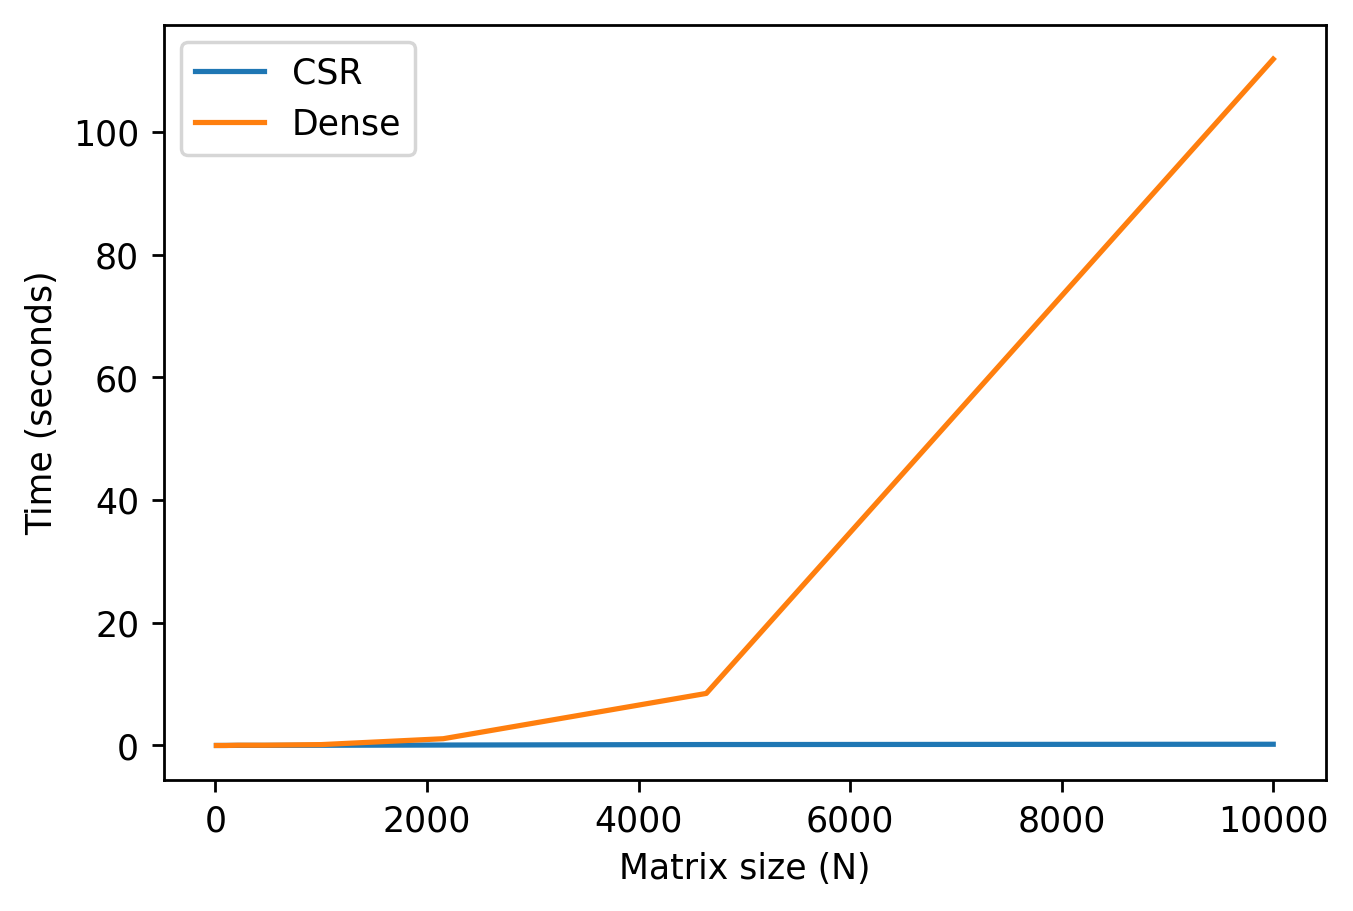

In [218]:
plt.figure(dpi=250)
plt.plot(n,store[:,0],label='CSR')
plt.plot(n,store[:,1],label='Dense')
plt.legend()
plt.xlabel('Matrix size (N)')
plt.ylabel('Time (seconds)')

In [ ]:
@jit
def helmholtz_if_loop(N):
    """IF loop for helmholtz mat function, separated for Numba speed up."""
    
    #creating arrays and intialising variables
    k = 5
    h = 1/N
    A_row = []
    A_col = []
    A_data = []
    A_shape = ((N-1)*(N-1),(N-1)*(N-1))
    b = np.zeros((N-1)*(N-1))
    coeff1 = (12 + h*h*k*k)/36
    coeff2 = (3 + h*h*k*k)/9

    #creating A matrix
    for i in prange((N-1)*(N-1)):
        for j in prange((N-1)*(N-1)):
            #same
            if i == j:
                A_row.append(i)
                A_col.append(j)
                A_data.append((24 - 4*h*h*k*k)/9)
            #horizontal adj
            elif (((i==(j+1)) or (i==(j-1))) & (int(i/(N-1)) == int(j/(N-1)))):
                A_row.append(i)
                A_col.append(j)
                A_data.append((-3 - h*h*k*k)/9)
            #vertical adj
            elif (((i==(j+(N-1))) or (i==(j-(N-1)))) & (int(i/(N-1)) != int(j/(N-1)))):
                A_row.append(i)
                A_col.append(j)
                A_data.append((-3 - h*h*k*k)/9) 
            #diagonal adj
            elif (((i==(j+N)) or (i==(j+N-2)) or (i==(j-N)) or (i==(j-N+2))) & 
                  ((int(i/(N-1)) == (int(j/(N-1))+1)) or (int(i/(N-1)) == (int(j/(N-1))-1)))):
                A_row.append(i)
                A_col.append(j)
                A_data.append((-12 - h*h*k*k)/36)
            else:
                pass

    #creating b vector
    for j in prange((N-1)*(N-1)):
        #bottom left
        if j == 0:  
            b[j] = coeff1*(g(0,0)+g(2*h,0)+g(0,2*h)) + coeff2*(g(h,0) + g(0,h))
        #bottom right
        elif j == (N-2):
            b[j] = coeff1*(g(1,0)+g(1,2*h)+g(1-2*h,0)) + coeff2*(g(1-h,0) + g(1,h))
        #top left
        elif j == (N*N - 3*N + 2):
            b[j] = coeff1*(g(0,1)+g(2*h,1)+g(0,1-2*h)) + coeff2*(g(h,1) + g(0,1-h))
        #top right
        elif j == (N*N - 2*N):
            b[j] = coeff1*(g(1,1)+g(1-2*h,1)+g(1,1-2*h)) + coeff2*(g(1-h,1) + g(1,1-h))
        #first column:
        elif (j%(N-1)) == 0:
            cj = (j/(N-1)+1)*h
            b[j] = coeff1*(g(0,cj+h)+g(0,cj-h)) + coeff2*g(0,cj)
        #last column:
        elif ((j+1)%(N-1)) == 0:
            cj = ( ((j+1)/(N-1)))*h
            b[j] = coeff1*(g(1,cj+h)+g(1,cj-h)) + coeff2*g(1,cj)
        #bottom row:
        elif j < (N-1):
            cj = (j+1)*h
            b[j] = coeff1*(g(cj+h,0)+g(cj-h,0)) + coeff2*g(cj,0)
        #top row:
        elif j > (N*N - 3*N + 1):
            cj = (j - N*N + 3*N -1)*h
            b[j] = coeff1*(g(cj+h,1)+g(cj-h,1)) + coeff2*g(cj,1)
        #other
        else:
            b[j] = 0
            
    return A_data, A_row, A_col, A_shape, b


def helmholtz_mat(N):
    """Creates a matrix A and vector b creating a vector matrix problem to approximately solve the Hemholtz 
    equation and converts it into a scipy COO format. 
    Returns
    A: (N-1)^2 * (N-1)^2 matrix in COO format
    b: (N-1)^2 vector"""
    
    A_data, A_row, A_col, A_shape, b = helmholtz_if_loop(N)
    
    #store in COO format
    A = sp.coo_matrix((A_data,(A_row,A_col)), shape = A_shape)
    
    return A, b